Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
#!git clone https://github.com/google-research/google-research.git

In [1]:
import sys
import os
import tarfile
import urllib
import zipfile

sys.path.append('./google-research')

# Examples of streaming and non streaming inference with TF/TFlite

## Imports

In [2]:
# TF streaming
from kws_streaming.models import models
from kws_streaming.models import utils
from kws_streaming.layers.modes import Modes


2024-02-18 10:37:01.720733: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [3]:
import tensorflow as tf
import numpy as np
import tensorflow.compat.v1 as tf1
import logging
from kws_streaming.models import model_params
from kws_streaming.train import model_flags
from kws_streaming.train import test
from kws_streaming.models import utils
from kws_streaming import data
tf1.disable_eager_execution()

In [4]:
config = tf1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf1.Session(config=config)

2024-02-18 10:37:10.998929: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-18 10:37:11.000783: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-02-18 10:37:11.007529: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-02-18 10:37:11.025028: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-18 10:37:11.025421: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce 

In [5]:
# general imports
import matplotlib.pyplot as plt
import os
import json
import numpy as np
import scipy as scipy
import scipy.io.wavfile as wav
import scipy.signal

In [6]:
tf.__version__

'2.4.0'

In [7]:
tf1.reset_default_graph()
sess = tf1.Session()
tf1.keras.backend.set_session(sess)
tf1.keras.backend.set_learning_phase(0)

2024-02-18 10:37:19.466785: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-02-18 10:37:19.466946: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-18 10:37:19.467075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.64GiB deviceMemoryBandwidth: 938.86GiB/s
2024-02-18 10:37:19.467096: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2024-02-18 10:37:19.467111: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2024-02-18 10:37:19.467118: I tensorflow/stream_executor/platfor

## Load wav file

In [25]:
def waveread_as_pcm16(filename):
  """Read in audio data from a wav file.  Return d, sr."""
  with open(filename, 'rb') as file_handle:
  #with tf.io.gfile.GFile(filename, 'rb') as file_handle:
    samplerate, wave_data = wav.read(file_handle)
  # Read in wav file.
  return wave_data, samplerate

def wavread_as_float(filename, target_sample_rate=16000):
  """Read in audio data from a wav file.  Return d, sr."""
  wave_data, samplerate = waveread_as_pcm16(filename)
  desired_length = int(
      round(float(len(wave_data)) / samplerate * target_sample_rate))
  wave_data = scipy.signal.resample(wave_data, desired_length)

  # Normalize short ints to floats in range [-1..1).
  data = np.array(wave_data, np.float32) / 32768.0
  return data, target_sample_rate

In [14]:
# set PATH to data sets (for example to speech commands V2):
# it can be downloaded from
# https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
# if you run 00_check-data.ipynb then data2 should be located in the current folder
current_dir = os.getcwd()
DATA_PATH = os.path.join(current_dir, "data2/")

In [15]:
DATA_PATH

'/mnt/disk0shared/bdjola/Documents/Technique/DevML/kws_streaming2/kws_streaming/data2/'

In [26]:
# Set path to wav file for testing.
wav_file = os.path.join(DATA_PATH, "left/0a2b400e_nohash_0.wav")

# read audio file
wav_data, samplerate = wavread_as_float(wav_file)

In [27]:
assert samplerate == 16000

In [19]:
# for simple test instead of reading wav - just generate cos
# samplerate = 16000
# wav_data = np.cos(2.0*np.pi*8.0*np.arange(samplerate)/samplerate)

In [20]:
#assert samplerate == 16000
#sound.Play(wav_data, samplerate)

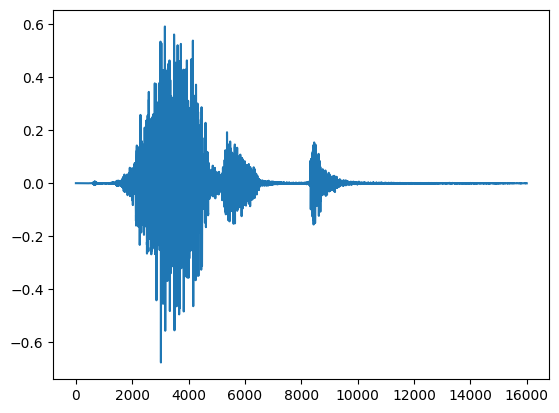

In [28]:
plt.plot(wav_data)

## Prepare batched model

In [30]:
# Set path to model weights and model parameters models trained on data set V2 can be downloaded from
# https://storage.googleapis.com/kws_models/models2.zip
# or from https://storage.googleapis.com/kws_models/models2_30k.zip
#MODEL_URL = "https://storage.googleapis.com/kws_models/models2_30k.zip"
#base_name = os.path.basename(MODEL_URL)
MODELS_PATH = current_dir
#base_name

In [ ]:
# it can take some time to download 2.3GB. After unpacking total size is 5.4GB
#arch_file_name = os.path.join(MODELS_PATH, base_name)
#if not os.path.isfile(arch_file_name):
  # download data
  #if sys.version_info >= (2, 5):
  #  file_path = urllib.request.urlretrieve(MODEL_URL, filename=arch_file_name)[0]
  #else:
  #  file_path = urllib.urlretrieve(MODEL_URL, filename=arch_file_name)[0]

  # unpack it
  #file_name, file_extension = os.path.splitext(base_name)
  #with zipfile.ZipFile(file_path, 'r') as zip_ref:
  #  zip_ref.extractall(MODELS_PATH)

In [31]:
MODELS_PATH

'/mnt/disk0shared/bdjola/Documents/Technique/DevML/kws_streaming2/kws_streaming'

In [32]:
file_name='models'
train_dir = os.path.join(MODELS_PATH, file_name, 'svdf')

In [34]:
train_dir

'/mnt/disk0shared/bdjola/Documents/Technique/DevML/kws_streaming2/kws_streaming/models/svdf'

In [36]:
# load command line command flags which were use for model creation/training
from argparse import Namespace
#with tf.compat.v1.gfile.Open(os.path.join(train_dir, 'flags.txt'), 'r') as fd:
#with open(os.path.join(train_dir, 'flags.txt'), 'r') as fd:
#  flags_txt = fd.read()
#flags = eval(flags_txt)

SyntaxError: invalid syntax (<string>, line 1)

In [37]:
flags_txt

'<kws_streaming.models.model_params.Params object at 0x7fdc182ed810>\n'

In [ ]:
# below is another way of reading flags - through json
with tf.compat.v1.gfile.Open(os.path.join(train_dir, 'flags.json'), 'r') as fd:
   flags_json = json.load(fd)

class DictStruct(object):
   def __init__(self, **entries):
     self.__dict__.update(entries)

flags = DictStruct(**flags_json)


In [ ]:
flags.data_dir = DATA_PATH

In [ ]:
# pad input audio with zeros, so that audio len = flags.desired_samples
padded_wav = np.pad(wav_data, (0, flags.desired_samples-len(wav_data)), 'constant')

input_data = np.expand_dims(padded_wav, 0)
input_data.shape

In [ ]:
# prepare mapping of index to word
audio_processor = data.input_data.AudioProcessor(flags)
index_to_label = {}
# labels used for training
for word in audio_processor.word_to_index.keys():
  if audio_processor.word_to_index[word] == data.input_data.SILENCE_INDEX:
    index_to_label[audio_processor.word_to_index[word]] = data.input_data.SILENCE_LABEL
  elif audio_processor.word_to_index[word] == data.input_data.UNKNOWN_WORD_INDEX:
    index_to_label[audio_processor.word_to_index[word]] = data.input_data.UNKNOWN_WORD_LABEL
  else:
    index_to_label[audio_processor.word_to_index[word]] = word

# training labels
index_to_label

In [ ]:
# we can create a dummy model
# flags = model_params.HOTWORD_MODEL_PARAMS['gru']
# flags = model_flags.update_flags(flags)

In [ ]:
# create model with flag's parameters
model_non_stream_batch = models.MODELS[flags.model_name](flags)

# load model's weights
weights_name = 'best_weights'
model_non_stream_batch.load_weights(os.path.join(train_dir, weights_name))

In [ ]:
#model_non_stream_batch.summary()

In [ ]:
tf.keras.utils.plot_model(
    model_non_stream_batch,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

## Run inference with TF

### TF Run non streaming inference

In [ ]:
# convert model to inference mode with batch one
inference_batch_size = 1
tf.keras.backend.set_learning_phase(0)
flags.batch_size = inference_batch_size  # set batch size

model_non_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.NON_STREAM_INFERENCE)
#model_non_stream.summary()

In [ ]:
tf.keras.utils.plot_model(
    model_non_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [ ]:
predictions = model_non_stream.predict(input_data)
predicted_labels = np.argmax(predictions, axis=1)

In [ ]:
predicted_labels

In [ ]:
index_to_label[predicted_labels[0]]

### TF Run streaming inference with internal state

In [ ]:
# convert model to streaming mode
flags.batch_size = inference_batch_size  # set batch size

model_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.STREAM_INTERNAL_STATE_INFERENCE)
#model_stream.summary()

In [ ]:
tf.keras.utils.plot_model(
    model_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [ ]:
# run streaming inference
start = 0
end = flags.window_stride_samples
while end <= input_data.shape[1]:
  stream_update = input_data[:, start:end]

  # get new frame from stream of data
  stream_output_prediction = model_stream.predict(stream_update)
  stream_output_arg = np.argmax(stream_output_prediction)

  # update indexes of streamed updates
  start = end
  end = start + flags.window_stride_samples

stream_output_arg

In [ ]:
index_to_label[stream_output_arg]

### TF Run streaming inference with external state

In [ ]:
# convert model to streaming mode
flags.batch_size = inference_batch_size  # set batch size

model_stream = utils.to_streaming_inference(model_non_stream_batch, flags, Modes.STREAM_EXTERNAL_STATE_INFERENCE)
#model_stream.summary()

In [ ]:
tf.keras.utils.plot_model(
    model_stream,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True)

In [ ]:

inputs = []
for s in range(len(model_stream.inputs)):
  inputs.append(np.zeros(model_stream.inputs[s].shape, dtype=np.float32))

reset_state = True

if reset_state:
  for s in range(len(model_stream.inputs)):
    inputs[s] = np.zeros(model_stream.inputs[s].shape, dtype=np.float32)

start = 0
end = flags.window_stride_samples
while end <= input_data.shape[1]:
  # get new frame from stream of data
  stream_update = input_data[:, start:end]

  # update indexes of streamed updates
  start = end
  end = start + flags.window_stride_samples

  # set input audio data (by default input data at index 0)
  inputs[0] = stream_update

  # run inference
  outputs = model_stream.predict(inputs)

  # get output states and set it back to input states
  # which will be fed in the next inference cycle
  for s in range(1, len(model_stream.inputs)):
    inputs[s] = outputs[s]

  stream_output_arg = np.argmax(outputs[0])
stream_output_arg

In [ ]:
index_to_label[stream_output_arg]

## Run inference with TFlite

### Run non streaming inference with TFLite

In [ ]:
# path = os.path.join(train_dir, 'tflite_non_stream')
# tflite_model_name = 'non_stream.tflite'

tflite_non_streaming_model = utils.model_to_tflite(sess, model_non_stream, flags, Modes.NON_STREAM_INFERENCE)

In [ ]:
# prepare TFLite interpreter
# with tf.io.gfile.Open(os.path.join(path, tflite_model_name), 'rb') as f:
#   model_content = f.read()

interpreter = tf.lite.Interpreter(model_content=tflite_non_streaming_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

inputs = []
for s in range(len(input_details)):
  inputs.append(np.zeros(input_details[s]['shape'], dtype=np.float32))

In [ ]:
padded_input = np.zeros((1, 16000), dtype=np.float32)
padded_input[:, :input_data.shape[1]] = input_data

In [ ]:
# set input audio data (by default input data at index 0)
interpreter.set_tensor(input_details[0]['index'], padded_input.astype(np.float32))

# run inference
interpreter.invoke()

# get output: classification
out_tflite = interpreter.get_tensor(output_details[0]['index'])

out_tflite_argmax = np.argmax(out_tflite)

out_tflite_argmax

In [ ]:
print(out_tflite)

In [ ]:
index_to_label[out_tflite_argmax]

### Run streaming inference with TFLite

In [ ]:
# path = os.path.join(train_dir, 'tflite_stream_state_external')
# tflite_model_name = 'stream_state_external.tflite'

tflite_streaming_model = utils.model_to_tflite(sess, model_non_stream, flags, Modes.STREAM_EXTERNAL_STATE_INFERENCE)

In [ ]:
# with tf.io.gfile.Open(os.path.join(path, tflite_model_name), 'rb') as f:
#   model_content = f.read()

interpreter = tf.lite.Interpreter(model_content=tflite_streaming_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

inputs = []
for s in range(len(input_details)):
  inputs.append(np.zeros(input_details[s]['shape'], dtype=np.float32))

In [ ]:
input_details[0]['shape']

In [ ]:
reset_state = True

# before processing new test sequence we can reset model state
# if we reset model state then it is not real streaming mode
if reset_state:
  for s in range(len(input_details)):
    print(input_details[s]['shape'])
    inputs[s] = np.zeros(input_details[s]['shape'], dtype=np.float32)

start = 0
end = flags.window_stride_samples
while end <= input_data.shape[1]:
  stream_update = input_data[:, start:end]
  stream_update = stream_update.astype(np.float32)

  # update indexes of streamed updates
  start = end
  end = start + flags.window_stride_samples

  # set input audio data (by default input data at index 0)
  interpreter.set_tensor(input_details[0]['index'], stream_update)

  # set input states (index 1...)
  for s in range(1, len(input_details)):
    interpreter.set_tensor(input_details[s]['index'], inputs[s])

  # run inference
  interpreter.invoke()

  # get output: classification
  out_tflite = interpreter.get_tensor(output_details[0]['index'])
  #print(start / 16000.0, np.argmax(out_tflite), np.max(out_tflite))

  # get output states and set it back to input states
  # which will be fed in the next inference cycle
  for s in range(1, len(input_details)):
    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    inputs[s] = interpreter.get_tensor(output_details[s]['index'])

  out_tflite_argmax = np.argmax(out_tflite)
out_tflite_argmax

In [ ]:
print(out_tflite)

In [ ]:
index_to_label[out_tflite_argmax]